#1. Load Forecasting (Short-term)


## Load Forecasting Model Approach

The foundation of this model is to predict energy demand (load) accurately over various time horizons. Here’s how I can approach this:

## Data Input for Load Forecasting:
1. **Historical Load Data**:
   - Daily or hourly historical load data from CAISO database.
   
2. **LMP Data**:
   - Day-ahead and real-time locational marginal prices (LMP) to gauge pricing trends and their impact on load demand.
   
3. **Renewable Generation Data**:
   - Solar and wind generation data, as renewables can influence load patterns (e.g., high solar generation may reduce grid reliance).
   
4. **Weather Data**:
   - Historical weather patterns affecting energy demand, such as temperature, humidity, and solar radiation levels.

## Methods for Forecasting:
### Short-Term Forecasting (Next 24-72 hours):
- **Time Series Forecasting** using models like ARIMA, Exponential Smoothing (ETS), or Prophet for forecasting hourly or daily load based on historical data.
- **Machine Learning (e.g., Random Forest or XGBoost)** to predict load considering multiple features like weather, LMP, and renewable generation.

### Long-Term Forecasting (Monthly/Annual):
- **Regression Models**: Use time series regression models, or multivariate regression with features like population growth, economic activity, and historical demand.
- **Scenario-based Forecasting**: Forecasting based on different scenarios (e.g., high renewable growth, shifts in customer behavior).


## Install and Verify CAISO GridStatus Package


The following commands will install the `gridstatus` package, upgrade it if already installed, and print its version to verify the installation. `gridstatus` provides access to real-time grid data from the California Independent System Operator (CAISO), allowing users to retrieve information about grid conditions, such as energy demand, supply, and other operational metrics relevant to CAISO's grid.


In [ ]:
!python -m pip install gridstatus
!python -m pip install --upgrade gridstatus
import gridstatus
print(gridstatus.__version__)

In [ ]:
!pip install prophet


## Setting up libraries

The following code imports several libraries and modules to facilitate data analysis, visualization, and interaction with the grid data:

- **`numpy`** and **`pandas`**: Used for numerical computations and data manipulation.
- **`matplotlib.pyplot`** and **`seaborn`**: Utilized for creating various types of data visualizations (e.g., plots, graphs).
- **`scipy.stats`**: Provides statistical functions to analyze data.
- **`IPython.core.interactiveshell`**: Modifies the interactive shell behavior to display all outputs in Jupyter/Colab cells.
- **`datetime` and `timedelta`**: Handle date and time manipulations, such as working with timestamps and date differences.
- **`tqdm_notebook`**: Displays a progress bar for iterative operations in Jupyter/Colab.
- **`gridstatus`**: Allows access to real-time grid data from the California Independent System Operator (CAISO), enabling retrieval of grid conditions such as energy demand, supply, and other operational metrics.

These libraries and modules together help with data analysis, visualization, real-time grid monitoring, and efficient interaction within a Jupyter/Colab environment.


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
import os
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

import gridstatus
from datetime import datetime, timedelta

from prophet import Prophet



## CAISO Data pull
The following code retrieves and processes data from the California Independent System Operator (CAISO) using the `gridstatus` package:

1. **Imports Libraries**:
   - `pandas` for data manipulation.
   - `datetime` and `timedelta` for handling date and time.
   - `gridstatus` for interacting with CAISO data (load, market prices, and renewable generation).

2. **Creates a CAISO object**:
   - Initializes the `CAISO()` object to interact with CAISO's data.

3. **Sets Start and End Dates**:
   - Defines a time window of the last 7 days to fetch data.

4. **Fetches Various Data**:
   - **Load Data**: Retrieves energy demand (load) data for the specified period.
   - **Day-Ahead Market Prices**: Retrieves day-ahead locational marginal prices (LMP) for hourly intervals.
   - **Real-Time Market Prices**: Retrieves real-time LMP for 5-minute intervals.
   - **Renewable Generation Data**: Retrieves solar and wind generation forecasts for the current day.

5. **Dataframes Creation**:
   - Converts the fetched data into `pandas` DataFrames for easier manipulation.

6. **Debugging**:
   - Prints the columns and a few rows of each DataFrame to inspect the fetched data.

7. **Merges DataFrames**:
   - Ensures all DataFrames have a consistent timestamp format.
   - Merges the data on time-related columns, combining load data, day-ahead prices, real-time prices, and renewable generation.

8. **Final Processing**:
   - Drops unnecessary columns, handles missing data, and prints the combined DataFrame for further analysis.


In [26]:
import pandas as pd
from datetime import datetime, timedelta
from gridstatus import CAISO, Markets

# Create CAISO object
caiso = CAISO()

# Set the start and end dates for data retrieval
end_date = datetime.now()
start_date = end_date - timedelta(days=7)  # Last 7 days

# Fetch load data (demand)
load_data = caiso.get_load(start=start_date, end=end_date)
load_df = pd.DataFrame(load_data)

# Fetch Day-Ahead market prices (Hourly)
day_ahead_prices = caiso.get_lmp(start=start_date, end=end_date, market=Markets.DAY_AHEAD_HOURLY)
day_ahead_df = pd.DataFrame(day_ahead_prices)

# Fetch Real-Time market prices (5-min)
real_time_prices = caiso.get_lmp(start=start_date, end=end_date, market=Markets.REAL_TIME_5_MIN)
real_time_df = pd.DataFrame(real_time_prices)

# Fetch renewable generation (solar and wind forecast)
today_date = end_date.strftime('%Y-%m-%d')
renewable_generation = caiso.get_solar_and_wind_forecast_dam(date=today_date)
renewable_df = pd.DataFrame(renewable_generation)

# Debugging: print column names and a few rows of each dataframe
print("Load Data Columns:", load_df.columns)
print(load_df.head())

print("\nDay-Ahead Prices Columns:", day_ahead_df.columns)
print(day_ahead_df.head())

print("\nReal-Time Prices Columns:", real_time_df.columns)
print(real_time_df.head())

print("\nRenewable Generation Columns:", renewable_df.columns)
print(renewable_df.head())

# Ensure all dataframes have the same timestamp format to allow merging
load_df['Interval Start'] = pd.to_datetime(load_df['Interval Start'])
day_ahead_df['Time'] = pd.to_datetime(day_ahead_df['Time'])
real_time_df['Time'] = pd.to_datetime(real_time_df['Time'])
renewable_df['Interval Start'] = pd.to_datetime(renewable_df['Interval Start'])

# Sort all dataframes
load_df = load_df.sort_values('Interval Start')
day_ahead_df = day_ahead_df.sort_values('Time')
real_time_df = real_time_df.sort_values('Time')
renewable_df = renewable_df.sort_values('Interval Start')

# Merge load_df with day_ahead_df using merge_asof for alignment (nearest time match)
combined_df = pd.merge_asof(load_df, day_ahead_df[['Time', 'LMP']],
                            left_on='Interval Start', right_on='Time', direction='nearest')

# Merge with real_time_df (5-minute data) using merge_asof
combined_df = pd.merge_asof(combined_df, real_time_df[['Time', 'LMP']],
                            left_on='Interval Start', right_on='Time', direction='nearest', suffixes=('_DA', '_RT'))

# Merge renewable_df (solar and wind generation) using merge_asof
combined_df = pd.merge_asof(combined_df, renewable_df[['Interval Start', 'Solar MW', 'Wind MW']],
                            left_on='Interval Start', right_on='Interval Start', direction='nearest')

# Handle missing values by forward filling
combined_df = combined_df.ffill()

# Select the relevant columns for the final output
combined_df = combined_df[['Interval Start', 'Load', 'LMP_DA', 'LMP_RT', 'Solar MW', 'Wind MW']]

# Debugging: show the final dataframe
print("\nCombined DataFrame:")
print(combined_df.head())

# Optional: Save the combined dataframe to a CSV file
# combined_df.to_csv('caiso_data.csv', index=False)


  0%|          | 0/8 [00:00<?, ?it/s]2025-03-18 21:28:29 - INFO - Fetching URL: https://www.caiso.com/outlook/history/20250311/demand.csv?_=1742333309
INFO:gridstatus:Fetching URL: https://www.caiso.com/outlook/history/20250311/demand.csv?_=1742333309
 12%|█▎        | 1/8 [00:00<00:01,  3.54it/s]2025-03-18 21:28:29 - INFO - Fetching URL: https://www.caiso.com/outlook/history/20250312/demand.csv?_=1742333309
INFO:gridstatus:Fetching URL: https://www.caiso.com/outlook/history/20250312/demand.csv?_=1742333309
 25%|██▌       | 2/8 [00:00<00:01,  4.28it/s]2025-03-18 21:28:29 - INFO - Fetching URL: https://www.caiso.com/outlook/history/20250313/demand.csv?_=1742333309
INFO:gridstatus:Fetching URL: https://www.caiso.com/outlook/history/20250313/demand.csv?_=1742333309
 38%|███▊      | 3/8 [00:00<00:00,  5.05it/s]2025-03-18 21:28:29 - INFO - Fetching URL: https://www.caiso.com/outlook/history/20250314/demand.csv?_=1742333309
INFO:gridstatus:Fetching URL: https://www.caiso.com/outlook/history/2

Load Data Columns: Index(['Time', 'Interval Start', 'Interval End', 'Load'], dtype='object')
                       Time            Interval Start  \
0 2025-03-11 00:00:00-07:00 2025-03-11 00:00:00-07:00   
1 2025-03-11 00:05:00-07:00 2025-03-11 00:05:00-07:00   
2 2025-03-11 00:10:00-07:00 2025-03-11 00:10:00-07:00   
3 2025-03-11 00:15:00-07:00 2025-03-11 00:15:00-07:00   
4 2025-03-11 00:20:00-07:00 2025-03-11 00:20:00-07:00   

               Interval End     Load  
0 2025-03-11 00:05:00-07:00  20752.0  
1 2025-03-11 00:10:00-07:00  21053.0  
2 2025-03-11 00:15:00-07:00  21213.0  
3 2025-03-11 00:20:00-07:00  21271.0  
4 2025-03-11 00:25:00-07:00  21195.0  

Day-Ahead Prices Columns: Index(['Time', 'Interval Start', 'Interval End', 'Market', 'Location',
       'Location Type', 'LMP', 'Energy', 'Congestion', 'Loss'],
      dtype='object')
                       Time            Interval Start  \
0 2025-03-11 22:00:00-07:00 2025-03-11 22:00:00-07:00   
1 2025-03-11 22:00:00-07:00 2025

In [27]:
# Print the combined table
combined_df.head(300)

,Interval Start,Load,LMP_DA,LMP_RT,Solar MW,Wind MW
0,2025-03-11 00:00:00-07:00,20752.0,62.60768,68.25950,0.0,2815.08
1,2025-03-11 00:05:00-07:00,21053.0,62.60768,68.25950,0.0,2815.08
2,2025-03-11 00:10:00-07:00,21213.0,62.60768,68.25950,0.0,2815.08
3,2025-03-11 00:15:00-07:00,21271.0,62.60768,68.25950,0.0,2815.08
4,2025-03-11 00:20:00-07:00,21195.0,62.60768,68.25950,0.0,2815.08
...,...,...,...,...,...,...
295,2025-03-12 00:35:00-07:00,21352.0,48.08791,65.95384,0.0,2815.08
296,2025-03-12 00:40:00-07:00,21265.0,48.08791,65.67647,0.0,2815.08
297,2025-03-12 00:45:00-07:00,21221.0,48.08791,63.10518,0.0,2815.08
298,2025-03-12 00:50:00-07:00,21155.0,48.08791,71.97926,0.0,2815.08


In [32]:
combined_df.info()
combined_df.describe()

min_date = combined_df['Interval Start'].min()
max_date = combined_df['Interval Start'].max()

print(f"Minimum date: {min_date}")
print(f"Maximum date: {max_date}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2189 entries, 0 to 2188
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype                     
---  ------          --------------  -----                     
 0   Interval Start  2189 non-null   datetime64[ns, US/Pacific]
 1   Load            2189 non-null   float64                   
 2   LMP_DA          2189 non-null   float64                   
 3   LMP_RT          2189 non-null   float64                   
 4   Solar MW        2189 non-null   float64                   
 5   Wind MW         2189 non-null   float64                   
dtypes: datetime64[ns, US/Pacific](1), float64(5)
memory usage: 102.7 KB


,Load,LMP_DA,LMP_RT,Solar MW,Wind MW
count,2189.000000,2189.000000,2189.000000,2189.000000,2189.000000
mean,21525.517588,37.883253,43.316170,267.037743,2676.663312
std,2930.651564,26.985054,64.760595,1738.131050,599.826753
min,13711.000000,-43.110440,-75.661790,0.000000,22.390000
25%,19788.000000,31.154310,33.955810,0.000000,2815.080000
50%,21544.000000,46.824810,47.366160,0.000000,2815.080000
75%,23624.000000,55.716050,60.097060,0.000000,2815.080000
max,27381.000000,71.969560,1063.805300,17912.660000,3267.220000


Minimum date: 2025-03-11 00:00:00-07:00
Maximum date: 2025-03-18 14:20:00-07:00


### Dataset Variable Explanations

This dataset contains information about electricity demand, pricing, and renewable energy generation. Here's an explanation of each variable:

## 1. Interval Start
- Timestamp for each data point
- Format: YYYY-MM-DD HH:MM:SS-07:00
- Represents the start of a 5-minute interval
- The -07:00 indicates a time zone offset (likely Pacific Time)

## 2. Load
- Electricity demand in megawatts (MW)
- Ranges from about 20,000 to 21,500 MW in the sample
- This is the target variable we're trying to forecast

## 3. LMP_DA (Locational Marginal Price - Day Ahead)
- Forecasted price of electricity for the next day
- Measured in MWh (dollars per megawatt-hour)
- Ranges from about 48 to 63 MWh in the sample

## 4. LMP_RT (Locational Marginal Price - Real Time)
- Actual price of electricity in real-time   
- Measured in MWh   
- Ranges from about 58 to 72 MWh in the sample   
- Generally more volatile than LMP_DA   

## 5. Solar MW
- Amount of solar power generation in megawatts
- All values are 0.0 in this sample, likely because these are nighttime hours

## 6. Wind MW
- Amount of wind power generation in megawatts
- Constant at 2815.08 MW in this sample, indicating steady wind generation

This dataset provides a comprehensive view of electricity demand, pricing, and renewable energy generation, which are all crucial factors in power system operations and forecasting.


<Figure size 1500x700 with 0 Axes>

Text(0.5, 1.0, 'CAISO Load Time Series')

Text(0.5, 0, 'Date and Time')

Text(0, 0.5, 'Load (MW)')

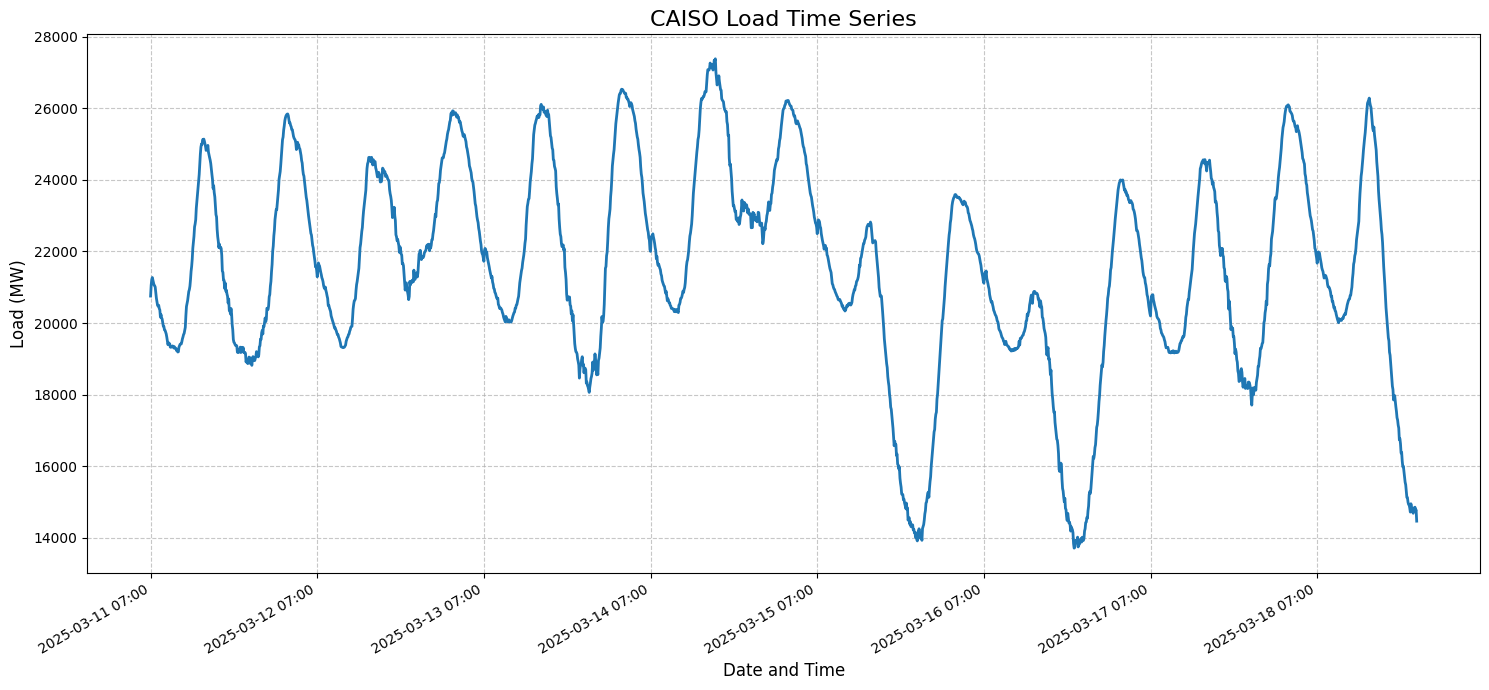

In [30]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Create the plot
plt.figure(figsize=(15, 7))
plt.plot(combined_df['Interval Start'], combined_df['Load'], linewidth=2)

# Customize the plot
plt.title('CAISO Load Time Series', fontsize=16)
plt.xlabel('Date and Time', fontsize=12)
plt.ylabel('Load (MW)', fontsize=12)

# Format x-axis to show dates nicely
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d %H:%M'))
plt.gcf().autofmt_xdate()  # Rotate and align the tick labels

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


### Using Facebook's Prophet for Short-Term Forecasting: Candidate Model #1 (no secondary data)


# Prophet Forecasting Summary

This code uses Facebook's Prophet model for time series forecasting:

## Training Period
- Start: 2025-03-11 00:00:00
- End: 2025-03-18 14:20:00

## Forecast Period
- Start: 2025-03-18 14:25:00
- End: 2025-03-20 14:20:00 (48 hours)

## Key Points
- Trains on entire dataset
- Forecasts 48 hours into future
- Plots historical data and forecast
- Not performing backtesting


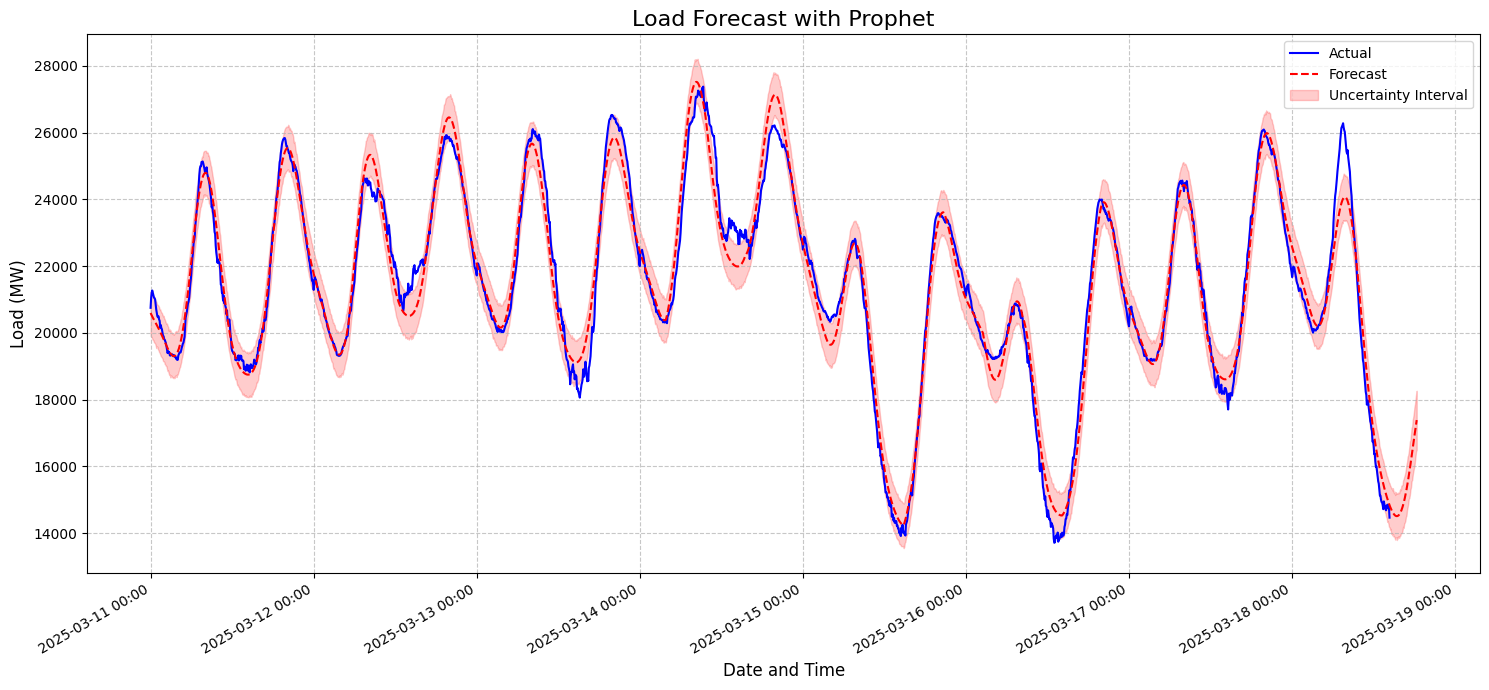

In [41]:
import logging
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Suppress INFO and DEBUG logs
logging.getLogger('prophet').setLevel(logging.ERROR)  # Suppress Prophet logs
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)  # Suppress cmdstanpy logs

# Assuming 'combined_df' is your DataFrame and it contains 'Interval Start' and 'Load'
# Rename columns to 'ds' (datetime) and 'y' (value) for Prophet
df_prophet = combined_df[['Interval Start', 'Load']].rename(columns={'Interval Start': 'ds', 'Load': 'y'})

# Remove timezone information from the 'ds' column, if present
df_prophet['ds'] = pd.to_datetime(df_prophet['ds']).dt.tz_localize(None)

# Create a Prophet model with yearly and weekly seasonality enabled (if needed)
model = Prophet(yearly_seasonality=True, weekly_seasonality=True)

# Fit the model to your data
model.fit(df_prophet)

# Create future dates for predictions - Predict for the next 48 hours
future = model.make_future_dataframe(periods=48, freq='5min')  # Adjust frequency as needed

# Get the forecast
forecast = model.predict(future)

# Create the plot
plt.figure(figsize=(15, 7))

# Plot actual values
plt.plot(df_prophet['ds'], df_prophet['y'], label='Actual', color='blue')

# Plot forecasted values
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red', linestyle='--')

# Plot uncertainty intervals
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.2, label='Uncertainty Interval')

# Customize the plot
plt.title('Load Forecast with Prophet', fontsize=16)
plt.xlabel('Date and Time', fontsize=12)
plt.ylabel('Load (MW)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Format x-axis to show dates nicely
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d %H:%M'))  # Corrected DateFormatter import
plt.gcf().autofmt_xdate()  # Rotate and align the tick labels

# Show the plot
plt.tight_layout()
plt.show();


### Testing Potential Candidate regressors for Energy Load Forecasting.

In [51]:
correlation_matrix = df_prophet[['y', 'LMP_DA', 'LMP_RT', 'Solar MW', 'Wind MW', 'hour', 'day_of_week']].corr()
print(correlation_matrix['y'].sort_values(ascending=False))


y              1.000000
LMP_DA         0.641957
LMP_RT         0.417919
hour           0.223469
Wind MW        0.121134
Solar MW      -0.104914
day_of_week   -0.192344
Name: y, dtype: float64


In [52]:
from statsmodels.tsa.stattools import coint

for column in ['LMP_DA', 'LMP_RT', 'Solar MW', 'Wind MW']:
    _, p_value, _ = coint(df_prophet['y'], df_prophet[column])
    print(f"Cointegration p-value for {column}: {p_value}")


Cointegration p-value for LMP_DA: 2.9536355088802294e-08
Cointegration p-value for LMP_RT: 0.0004394551508787068
Cointegration p-value for Solar MW: 1.484547908562676e-06
Cointegration p-value for Wind MW: 9.323331015045911e-13


In [53]:
from statsmodels.tsa.stattools import grangercausalitytests

for column in ['LMP_DA', 'LMP_RT', 'Solar MW', 'Wind MW']:
    granger_test = grangercausalitytests(df_prophet[['y', column]], maxlag=24)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=151.6126, p=0.0000  , df_denom=2185, df_num=1
ssr based chi2 test:   chi2=151.8207, p=0.0000  , df=1
likelihood ratio test: chi2=146.7851, p=0.0000  , df=1
parameter F test:         F=151.6126, p=0.0000  , df_denom=2185, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=31.7429 , p=0.0000  , df_denom=2182, df_num=2
ssr based chi2 test:   chi2=63.6312 , p=0.0000  , df=2
likelihood ratio test: chi2=62.7231 , p=0.0000  , df=2
parameter F test:         F=31.7429 , p=0.0000  , df_denom=2182, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=14.8976 , p=0.0000  , df_denom=2179, df_num=3
ssr based chi2 test:   chi2=44.8363 , p=0.0000  , df=3
likelihood ratio test: chi2=44.3827 , p=0.0000  , df=3
parameter F test:         F=14.8976 , p=0.0000  , df_denom=2179, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=9.8581  , p=0.

In [54]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df_prophet[['LMP_DA', 'LMP_RT', 'Solar MW', 'Wind MW', 'hour', 'day_of_week']]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)


      Variable       VIF
0       LMP_DA  3.984686
1       LMP_RT  1.775426
2     Solar MW  1.068864
3      Wind MW  9.786330
4         hour  3.572273
5  day_of_week  3.443268


In [55]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, df_prophet['y'])
importance = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
print(importance.sort_values('importance', ascending=False))


RandomForestRegressor(random_state=42)

       feature  importance
0       LMP_DA    0.392812
4         hour    0.344225
1       LMP_RT    0.131726
5  day_of_week    0.111404
2     Solar MW    0.015965
3      Wind MW    0.003868
